In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
import datetime
import numpy as np
import pickle
from tqdm.notebook import tqdm
from functools import partial
import tensorflow.keras.layers.experimental.preprocessing as preprocess
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
import math,os
import keras_tuner as kt
from tensorflow.keras.regularizers import l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import glob

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)


In [3]:
gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
classes = ['airplane',										
'automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck']


In [3]:

(training_images, training_labels), (validation_images,
                                     validation_labels) = tf.keras.datasets.cifar10.load_data()

depth = 10
y_train = tf.one_hot(tf.squeeze(training_labels), depth)
X_train = training_images/255.0
y_valid = tf.one_hot(tf.squeeze(validation_labels), depth)
X_valid = validation_images/255.0

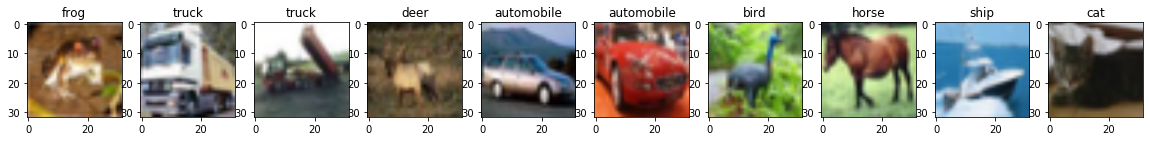

In [4]:
i = 8
_, axes = plt.subplots(1,10, figsize =(20,3), facecolor = 'white')
for i in range(10):

    axes[i].imshow(X_train[i], interpolation= 'bilinear')
    axes[i].set_title(classes[tf.argmax(y_train[i], axis = 0)])

In [5]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, **kwargs):
        super().__init__(**kwargs)

        self.activation = tf.keras.layers.LeakyReLU()

        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()]

        self.skip_layers = []

        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs

        for layer in self.main_layers:
            Z = layer(Z)

        skip_Z = inputs

        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

In [ ]:

def model_builder(hp):
    model = tf.keras.models.Sequential()

    model.add(layers.Input([32, 32, 3]))

    model.add(preprocess.RandomFlip())
    model.add(preprocess.Normalization())
    model.add(preprocess.RandomRotation(0.3))

    model.add(DefaultConv2D(64, kernel_size=7,
              strides=2, input_shape=[32, 32, 3]))
              
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=3, strides=2, padding="SAME"))

    prev_filters = 64

    n64 = hp.Choice('n_filters_64', values=[ 4, 6, 8, 10])
    n128 = hp.Choice('n_filters_128', values=[ 4, 6, 8, 10])
    n256 = hp.Choice('n_filters_256', values=[ 4, 6, 8, 10])
    n512 = hp.Choice('n_filters_512', values=[ 4, 6, 8, 10])

    for filters in [64] * n64 + [128] * n128 + [256] * n256 + [512] * n512:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters

    model.add(tf.keras.layers.GlobalAvgPool2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation="softmax"))


    lr = hp.Choice('learning_rate', values=[ 1e-3, 1e-4, 1e-5])
    weight_decay = hp.Choice('Weight_decay', values=[ 1e-3, 1e-4, 1e-5])

    optim = tf.keras.optimizers.Adamax(learning_rate=lr, decay=weight_decay)

    model.compile( optimizer=optim, loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')

    return model

In [6]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
                     

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [7]:
tuner.search(X_train[0:1000], y_train[0:1000], epochs=1, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 00m 25s]
val_accuracy: 0.11500000208616257

Best val_accuracy So Far: 0.17499999701976776
Total elapsed time: 00h 01m 57s
INFO:tensorflow:Oracle triggered exit


In [8]:
best_hps.values

{'n_filters_64': 8,
 'n_filters_128': 6,
 'n_filters_256': 6,
 'n_filters_512': 4,
 'learning_rate': 0.001,
 'Weight_decay': 0.0001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [110]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)


k_weight_decay = 1e-4

class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)

        self.activation = tf.keras.layers.ReLU()

        self.init = tf.keras.initializers.HeNormal()

        self.main_layers = [
            DefaultConv2D(filters, strides=strides, kernel_regularizer=regularizers.l2(k_weight_decay), kernel_initializer= self.init, ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            DefaultConv2D(filters, kernel_initializer= self.init,kernel_regularizer=regularizers.l2(k_weight_decay),),
            tf.keras.layers.BatchNormalization()]

        self.skip_layers = []

        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides, kernel_initializer= self.init,kernel_regularizer=regularizers.l2(k_weight_decay),),
                tf.keras.layers.BatchNormalization()
                
                ]

    def call(self, inputs):

        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

def Resnet():

    init = tf.keras.initializers.HeNormal()
  
    input = layers.Input([32, 32, 3])
    x = preprocess.RandomFlip()(input)
    x = preprocess.Normalization()(x)
 

    x = DefaultConv2D(64, kernel_size=3, strides=2,kernel_initializer= init,kernel_regularizer=regularizers.l2(k_weight_decay), )(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME")(x)


    prev_filters = 64
    for filters in [64] * 8 + [128] * 6 + [256] * 6 + [512] * 4:
        strides = 1 if filters == prev_filters else 2
        x = ResidualUnit(filters, strides=strides)(x)
        prev_filters = filters


    x = layers.GlobalAvgPool2D()(x)
    x = layers.Flatten()(x)
    x = MCDropout(0.5)(x)
    x = layers.Dense(10, activation="softmax", kernel_initializer= init,kernel_regularizer=regularizers.l2(k_weight_decay),)(x)

    model= Model(input, x)
    model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')

    return model

model = Resnet()


In [111]:
path = "./checkpoints/DA_1/" + 'Train' + '/'
model_load = tf.keras.models.load_model(path)
print("Restored")

model.set_weights(model_load.get_weights()) 

model.summary()

Restored
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 16, 16, 64)        1728      
_________________________________________________________________
batch_normalization_144 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_102 (ReLU)             (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit_66 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_67 (ResidualUn (None, 8, 8, 64)

In [112]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(X_train)

In [141]:
lr = 1e-10

def step_decay(epoch):
    initial_lrate = lr
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
print(model.optimizer.lr.numpy())


1e-10


In [143]:
batch_size = 256

history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=10,
    verbose=1,
    shuffle=True,
    validation_data=(X_valid, y_valid),
    callbacks=[lrate],

    )

Epoch 1/10
195/195 [==============================] - 30s 153ms/step - loss: 0.2849 - accuracy: 0.9531 - val_loss: 0.7353 - val_accuracy: 0.8473
Epoch 2/10
195/195 [==============================] - 27s 136ms/step - loss: 0.2900 - accuracy: 0.9511 - val_loss: 0.7373 - val_accuracy: 0.8479
Epoch 3/10
195/195 [==============================] - 28s 141ms/step - loss: 0.2879 - accuracy: 0.9508 - val_loss: 0.7347 - val_accuracy: 0.8454
Epoch 4/10
195/195 [==============================] - 26s 135ms/step - loss: 0.2934 - accuracy: 0.9486 - val_loss: 0.7356 - val_accuracy: 0.8475
Epoch 5/10
195/195 [==============================] - 25s 130ms/step - loss: 0.2894 - accuracy: 0.9515 - val_loss: 0.7359 - val_accuracy: 0.8464
Epoch 6/10
195/195 [==============================] - 28s 141ms/step - loss: 0.2864 - accuracy: 0.9524 - val_loss: 0.7376 - val_accuracy: 0.8459
Epoch 7/10
195/195 [==============================] - 27s 137ms/step - loss: 0.2923 - accuracy: 0.9503 - val_loss: 0.7364 - val_ac

In [144]:
path = "D:/Assignment-8/History_1/" +datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_file.pkl'
with open(path, 'wb') as files:
    pickle.dump(history.history, files)


In [97]:
path = "./checkpoints/DA_1/" + 'Train' + '/'
model.save(path)
print("checkpoint saved !")

INFO:tensorflow:Assets written to: ./checkpoints/DA_1/Train/assets
checkpoint saved !


In [98]:
def dropout_predictions(X_valid, y_valid):
    X, y = X_valid, y_valid
    actual = tf.argmax(y, axis=1)

    y_probas = tf.zeros(shape = y.shape, dtype = tf.float32)

    for model_ in tqdm(range(20)):
        y_probas = tf.math.add(y_probas , model(X))
    
    y_proba = tf.math.divide(y_probas, 10)
    prediction = tf.argmax(y_proba, axis = 1)
    return actual, prediction


actual, prediction = dropout_predictions(X_valid, y_valid)

In [99]:
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(actual, prediction)}\n")

Classification report for classifier:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1000
           1       0.91      0.93      0.92      1000
           2       0.83      0.80      0.82      1000
           3       0.75      0.67      0.70      1000
           4       0.85      0.81      0.83      1000
           5       0.79      0.74      0.77      1000
           6       0.81      0.94      0.87      1000
           7       0.87      0.90      0.88      1000
           8       0.93      0.90      0.92      1000
           9       0.86      0.91      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000




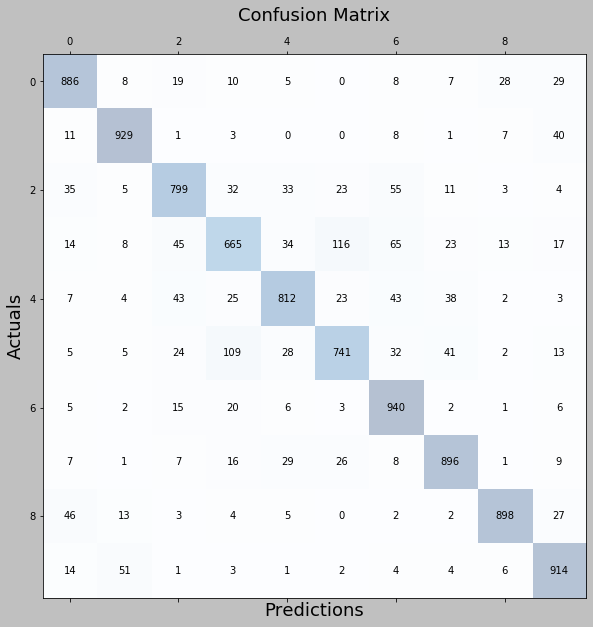

In [100]:
conf_matrix = confusion_matrix(actual, prediction)

fig, ax = plt.subplots(figsize=(10, 10),  facecolor='silver')
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [145]:
paths = [f for f in glob.glob("D:\Assignment-8\History_1/*.pkl")]

In [146]:
loss = []
accuracy = []
val_loss = []
val_accuracy = []
lr = []

for path in paths:
    with open(path, 'rb') as files:
        g = pickle.load(files)
        
    loss += g['loss']
    accuracy += g['accuracy']
    val_loss += g['val_loss']
    val_accuracy += g['val_accuracy']
    lr += g['lr']

No handles with labels found to put in legend.


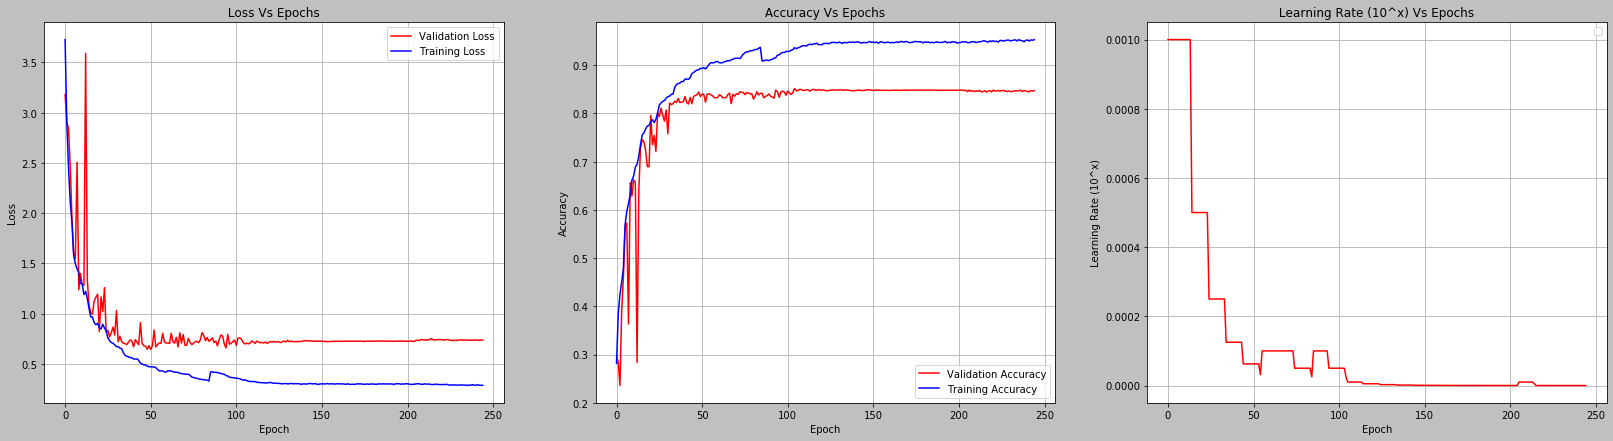

In [148]:
_, ax = plt.subplots(1, 3, figsize=(28, 7), facecolor='silver')
ax[0].set_facecolor('white')
ax[0].plot(val_loss, "red", label="Validation Loss")
ax[0].plot(loss, "blue", label="Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title(
    " Loss Vs Epochs ")
ax[0].grid()
ax[0].legend()


ax[1].set_facecolor('white')
ax[1].plot(val_accuracy , "red", label="Validation Accuracy")
ax[1].plot(accuracy , "blue", label="Training Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(
    " Accuracy Vs Epochs ")
ax[1].grid()
ax[1].legend()


ax[2].set_facecolor('white')
ax[2].plot(lr, "red")

ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Learning Rate (10^x)")
ax[2].set_title(
    " Learning Rate (10^x) Vs Epochs ")
ax[2].grid()
ax[2].legend()

# Model 2

In [30]:
(training_images, training_labels), (validation_images,
                                     validation_labels) = tf.keras.datasets.cifar10.load_data()

depth = 10
y_train = tf.one_hot(tf.squeeze(training_labels), depth)
X_train = training_images/255.0
y_test = tf.one_hot(tf.squeeze(validation_labels), depth)
X_valid = validation_images/255.0


In [25]:
#z-score
mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_train,axis=(0,1,2,3))
x_train = (X_train-mean)/(std+1e-7)
x_test = (X_valid-mean)/(std+1e-7)


num_classes= 10


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [26]:
baseMapNum = 32
weight_decay = 1e-4
model = Sequential()

model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)       